In [72]:
from sympy import *
init_printing()

In [73]:
import pandas as pd

# File paths
file_path_bygholm = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Bygholm Skov_DMI.csv"
file_path_hesselballe = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Hesselballe_DMI.csv"
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_Kørup_Parken_VNF_døgn_1975-2023.csv"

# Read CSVs with correct delimiter and skip headers
bygholm_df = pd.read_csv(file_path_bygholm, skiprows=13, encoding="ISO-8859-1", delimiter=";")
hesselballe_df = pd.read_csv(file_path_hesselballe, skiprows=13, encoding="ISO-8859-1", delimiter=";")
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names (remove leading spaces)
bygholm_df.columns = bygholm_df.columns.str.strip()
hesselballe_df.columns = hesselballe_df.columns.str.strip()
korup_parken_df.columns = korup_parken_df.columns.str.strip()

# Rename columns to match R
bygholm_df.columns = ["timestamp", "NedbørByg", "ksMRK"]
hesselballe_df.columns = ["timestamp", "NedbørHessel", "ksMRK"]
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime format
bygholm_df["timestamp"] = pd.to_datetime(bygholm_df["timestamp"], format="%d-%m-%Y")
hesselballe_df["timestamp"] = pd.to_datetime(hesselballe_df["timestamp"], format="%d-%m-%Y")
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Merge datasets on timestamp (left join)
merged_df = korup_parken_df.copy()
merged_df = merged_df.merge(bygholm_df[["timestamp", "NedbørByg"]], on="timestamp", how="left")
merged_df = merged_df.merge(hesselballe_df[["timestamp", "NedbørHessel"]], on="timestamp", how="left")

# Remove rows where NedbørByg or NedbørHessel is missing
merged_df = merged_df.dropna(subset=["NedbørByg", "NedbørHessel"])

# Create a sequential Time index
merged_df["Time"] = range(len(merged_df))

# reset index
merged_df = merged_df.reset_index(drop=True)

# Display the cleaned and merged dataset
print(shape(merged_df))
merged_df.head()

(5110, 6)


,timestamp,KarupBro,BygholmPark,NedbørByg,NedbørHessel,Time
0,2010-01-04,1806.75,NaN,0.2,0.2,0
1,2010-01-05,1676.60,NaN,0.6,0.5,1
2,2010-01-06,1562.37,NaN,0.3,0.2,2
3,2010-01-07,1427.74,NaN,0.0,0.1,3
4,2010-01-08,1280.80,NaN,0.0,0.0,4


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define input features (predictors)
X = merged_df[["NedbørByg", "NedbørHessel"]]

# Define target variable (water level)
y = merged_df["KarupBro"]

## Adding lag feature

In [75]:
# Add previous day's inflow as a new feature
merged_df["KarupBro_Lag1"] = merged_df["KarupBro"].shift(1)

# Drop NaN rows caused by shifting
merged_df = merged_df.dropna()

# Update feature set
X = merged_df[["NedbørByg", "NedbørHessel", "KarupBro_Lag1"]]
y = merged_df["KarupBro"]
merged_df.head()

,timestamp,KarupBro,BygholmPark,NedbørByg,NedbørHessel,Time,KarupBro_Lag1
2919,2018-01-01,5514.82,7276.83,7.4,0.0,2919,3890.08
2920,2018-01-02,5977.06,7869.38,0.0,0.0,2920,5514.82
2921,2018-01-03,5806.45,7650.67,11.9,0.0,2921,5977.06
2922,2018-01-04,6615.08,8687.25,3.2,2.9,2922,5806.45
2923,2018-01-05,5954.76,7840.79,0.0,0.0,2923,6615.08


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [77]:
X_train.size, X_test.size, y_train.size, y_test.size

(5256, 1317, 1752, 439)

In [78]:
y_test.head() , y_train.tail()

(4671     479.34
 4672     449.68
 4673    1288.98
 4674    1847.12
 4675    1381.71
 Name: KarupBro, dtype: float64,
 4666    460.24
 4667    447.86
 4668    606.36
 4669    577.50
 4670    526.95
 Name: KarupBro, dtype: float64)

In [79]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Model Coefficients: [35.43861953  9.57106827  0.95177938]
Intercept: -11.699995521224992


In [80]:
# Predict on test data
y_pred = model.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error (MAE): 303.81
Root Mean Squared Error (RMSE): 523.05
Mean Squared Error (MSE): 273584.81
R² Score: 0.938


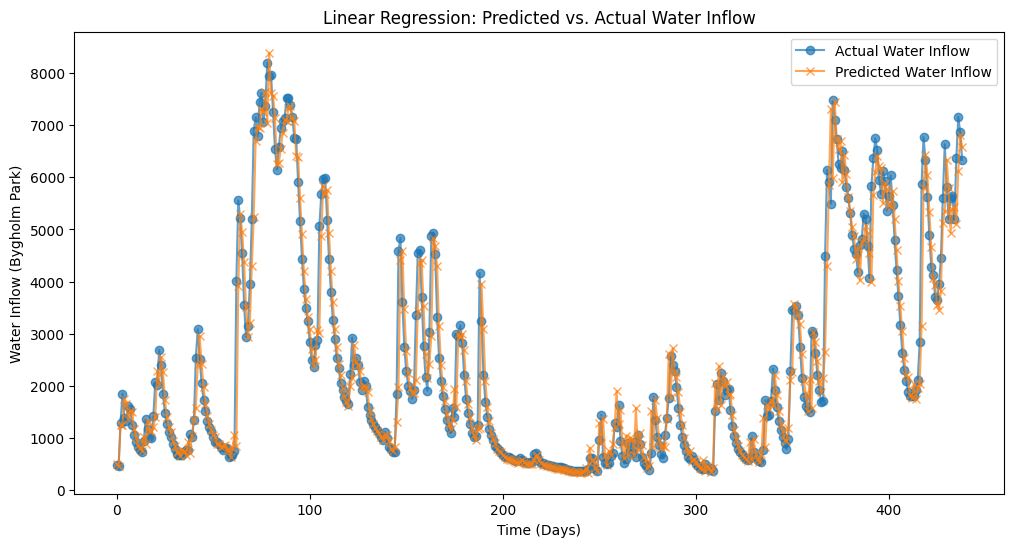

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Water Inflow", linestyle="-", marker="o", alpha=0.7)
plt.plot(y_pred, label="Predicted Water Inflow", linestyle="-", marker="x", alpha=0.7)
plt.legend()
plt.xlabel("Time (Days)")
plt.ylabel("Water Inflow (Bygholm Park)")
plt.title("Linear Regression: Predicted vs. Actual Water Inflow")
plt.show()


               NedbørByg  NedbørHessel  KarupBro  KarupBro_Lag1
NedbørByg       1.000000      0.797038  0.201661       0.104467
NedbørHessel    0.797038      1.000000  0.247363       0.156739
KarupBro        0.201661      0.247363  1.000000       0.965435
KarupBro_Lag1   0.104467      0.156739  0.965435       1.000000


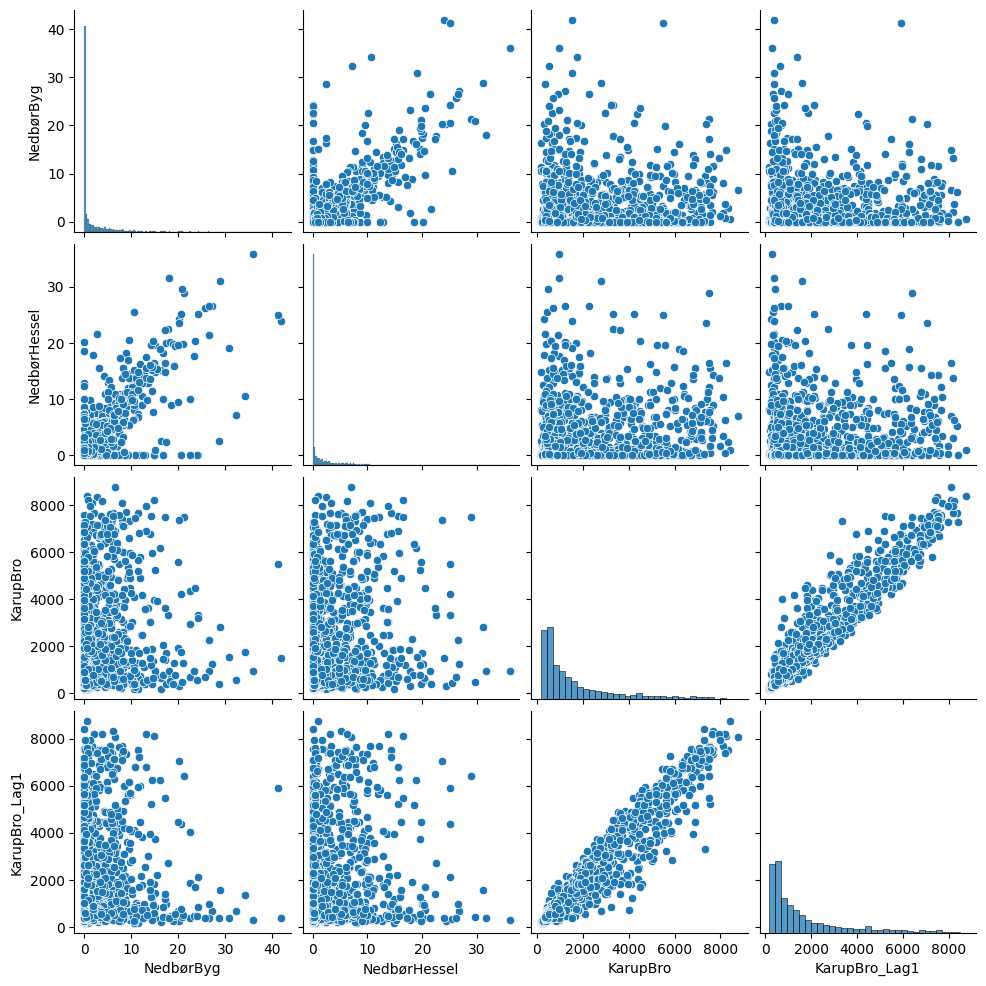

In [82]:
import seaborn as sns

correlation_matrix = merged_df[["NedbørByg", "NedbørHessel", "KarupBro", "KarupBro_Lag1"]].corr()
print(correlation_matrix)

sns.pairplot(merged_df[["NedbørByg", "NedbørHessel", "KarupBro", "KarupBro_Lag1"]])
plt.show()